<img src="https://www.rp.edu.sg/images/default-source/default-album/rp-logo.png" width="200" alt="Republic Polytechnic"/>

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/koayst-rplesson/C3669C-2025-01/blob/main/L14/L14_Answer.ipynb)

# Setup and Installation

You can run this Jupyter notebook either on your local machine or run it at Google Colab (preferred).

* For local machine, it is recommended to install Anaconda and create a new development environment called `c3669c`.
* Pip/Conda install the libraries stated below when necessary.
---

# <font color='red'>ATTENTION</font>

## Google Colab
- If you are running this code in Google Colab, **DO NOT** store the API Key in a text file and load the key later from Google Drive. This is insecure and will expose the key.
- **DO NOT** hard code the API Key directly in the Python code, even though it might seem convenient for quick development.
- You need to enter the API key at Python code `getpass.getpass()` when ask.

## Local Environment/Laptop
- If you are running this code locally in your laptop, you can create a env.txt and store the API key there.
- Make sure env.txt is in the same directory of this Jupyter notebook.
- You need to install `python-dotenv` and run the Python code to load in the API key.

---
```
%pip install python-dotenv

from dotenv import load_dotenv

load_dotenv('env.tx')
openai_api_key = os.getenv('OPENAI_API_KEY')
```
---

## GitHub/GitLab
- **DO NOT** `commit` or `push` API Key to services like GitHub or GitLab.

## Tip
The output from LangChain/LangGraph is a complex data structure and can be difficult to read/understand. Use [Python Formatter](https://codebeautify.org/python-formatter-beautifier) to format the output for easy reading.

# Lesson 14

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain
%pip install --quiet -U langgraph
%pip install --quiet -U langchain-openai
%pip install --quiet -U langchain-community
%pip install --quiet -U grandalf

In [ ]:
# langchain              0.3.11
# langgraph              0.2.59
# langchain-core         0.3.24
# langchain-openai       0.2.12
# langchain-community    0.3.12
# openai                 1.57.2
# pydantic               2.10.3

In [2]:
import getpass
import os

# setup the OpenAI API Key

# get OpenAI API key ready and enter it when ask
os.environ["OPENAI_API_KEY"] = getpass.getpass()

··········


## LangGraph

LangGraph is an abstraction or framework designed to model workflows, processes, or computations as directed graphs. It is often used in systems that require structured and modular workflows, particularly in natural language processing (NLP), AI pipelines, or decision-making applications.

In a LangGraph-style architecture, nodes represent individual tasks or operations, and edges define the flow of information between these tasks.  Every node is a function. Each node in the graph encapsulates a specific piece of functionality. It takes an input, performs a computation or action and produces an output.

Edge as data flow. The connections between nodes represent the flow of data or the results from one function to the next.

## Basic Chatbot

Let's build a basic chatbot.

References: [LangGraph Quick Start ](https://langchain-ai.github.io/langgraph/tutorials/introduction/#setup), [LangChain Academy](https://academy.langchain.com/)</br></br>
This chatbot will respond directly to user message. Though simple, it will illustrate the core concepts of building with LangGraph.

Start by creating a `StateGraph` that defines the "state" machine of the chatbot.  `Node` representing the LLM is added and `edges` to specify how the bot should transition between these functions.

In [3]:
from typing import Annotated
from typing_extensions import TypedDict

from langchain_core.messages import AnyMessage

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_openai import ChatOpenAI
from langchain_core.prompts.chat import ChatPromptTemplate

In [4]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    #
    # pre-built 'add_message' is also known as 'reducer'
    # reducer allows us to specify how stat updates are performed
    messages: Annotated[list[AnyMessage], add_messages]

In [5]:
# initialise the graph

graph_builder = StateGraph(State)

In [6]:
# setup the LLM model

model = ChatOpenAI(
    model = 'gpt-4o-mini',
    temperature = 0
)

### Create the 'chatbot' node

In [7]:
# notice how the chatbot node function takes the current State as input and returns a dictionary containing an updated
# messages list under the key "messages". This is the basic pattern for all LangGraph node functions.

def chatbot(state: State):
    return {
        'messages' : [model.invoke(state['messages'])]
    }

### Add 'chatbot' node to graph

In [8]:
# the first argument is the unique node name
# the second argument is the function or object that will be called whenever the node is used

graph_builder.add_node("chatbot", chatbot)

### Connect 'START' node to 'chatbot' node

In [9]:
graph_builder.add_edge(START, 'chatbot')

### Connect 'chatbot' node to 'END' node

In [10]:
graph_builder.add_edge("chatbot", END)

### Build the graph

In [11]:
graph = graph_builder.compile()

### Display the graph

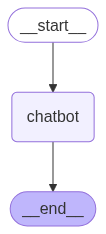

In [12]:
from IPython.display import Image, display

def drawGraph(graph):
    try:
        display(Image(graph.get_graph().draw_mermaid_png()))
    except Exception:
        # This requires some extra dependencies and is optional
        pass

# visualise the graph as a Mermaid diagram
drawGraph(graph)

# notice in the diagram, the arrow is a solid line
# dotted line denotes conditional edges

### Run the chatbot

In [13]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)
        print()

In [14]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

# Inputs:
# 1.  User: What is quantum computing?
# 2.  User: exit

User: What is quantum computing?
Assistant: Quantum computing is a type of computation that takes advantage of the principles of quantum mechanics to process information in fundamentally different ways than classical computers. While classical computers use bits as the smallest unit of data, which can be either 0 or 1, quantum computers use quantum bits, or qubits. Qubits can exist in multiple states simultaneously due to a property called superposition, allowing them to represent both 0 and 1 at the same time.

In addition to superposition, quantum computing also leverages another quantum phenomenon called entanglement, where the state of one qubit can be dependent on the state of another, no matter the distance between them. This allows quantum computers to perform complex calculations more efficiently than classical computers for certain types of problems.

Quantum computers have the potential to solve problems that are currently intractable for classical computers, such as factorin

---

## Tools

Tools are useful whenever you want a model to interact with external systems.</br>

In order for the chatbot to handle queries not "from memory", we need to integrate a web search tool. The bot will use Tavily Search to find the relevant information and provide better responses.

In [15]:
from typing import Annotated

from langchain_core.messages.human import HumanMessage

from langgraph.graph.message import add_messages
from langgraph.graph import MessagesState

from langgraph.graph import StateGraph, START, END

The code pattern for MessagesState when we want to appends messages to the list, rather than overwriting them is:

```
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
```

Since having a list of messages in graph state is so common, `LangGraph` has a pre-built `MessageState` as shown in the class definition `MessagesState`. ↓

In [16]:
class MessagesState(MessagesState):
    # add any keys needed beyond messages, which is pre-built
    pass

### A Simple Example of Tool Calling

In [17]:
from langchain_openai import ChatOpenAI
from langchain_core.messages.human import HumanMessage

In [18]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b

    Args:
    a: first int
    b: second int
    """
    return a * b

In [19]:
model = ChatOpenAI(
    model = 'gpt-4o-mini',
    temperature = 0
)

In [20]:
# notice you call bind_tools using a list
# that's mean you can add in more than one tool into the list

model_with_tools = model.bind_tools([multiply])

In [21]:
# let's test the tool
messages = model_with_tools.invoke(
    [HumanMessage(content=f"What is 4 multiplied by 8?")]
)

tool = {'multiply' : multiply}[messages.tool_calls[0]['name'].lower()]
print(tool(**(messages.tool_calls[0]['args'])))

32


---

### Use `MessagesState` with a Graph

In [22]:
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage

In [23]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b

    Args:
    a: first int
    b: second int
    """
    return a * b

In [24]:
model = ChatOpenAI(
    model = 'gpt-4o-mini',
    temperature = 0
)

model_with_tools = model.bind_tools([multiply])

In [25]:
def tool_calling_model(state: MessagesState):
    response = {"messages" : [model_with_tools.invoke(state['messages'])]}
    print(f">>> tool_calling_model: {response}\n")

    return response

In [26]:
help(tools_condition)

# accordingly, tools_condition is a perbuilt tool that "Use in the conditional_edge to route to the ToolNode
# if the last message has tool calls. Otherwise, route to the end

Help on function tools_condition in module langgraph.prebuilt.tool_node:

tools_condition(state: Union[list[Annotated[Union[Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='SystemMessageChunk')], Annotated[langchain_core.messages.function.FunctionMessageChunk, Tag(tag='FunctionMessageC

In [27]:
# Build Graph

graph_builder = StateGraph(MessagesState)

graph_builder.add_node('tool_calling_model', tool_calling_model)
graph_builder.add_node('tools', ToolNode([multiply]))

graph_builder.add_edge(START, 'tool_calling_model')

graph_builder.add_conditional_edges(
    "tool_calling_model",
    tools_condition
)

graph_builder.add_edge('tools', END)

graph = graph_builder.compile()

# 1. START is connected to 'tool_calling_model'
# 2. 'tool_calling_model' is connected to 'tool_condition'
# 3. When 'tool_calling_model' is passed a user request, it will return a response indicating tool calls is requested or not
# 4. 'tool_condition' will route to 'tools' (ToolNode) to perform "multiply" if there is tool call else to END
# 5. 'tools' is connected to END

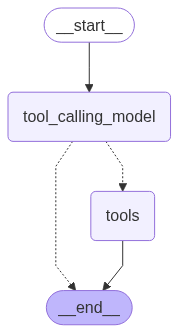

In [28]:
# View Graph
drawGraph(graph)

In [29]:
help(graph_builder.add_conditional_edges)

Help on method add_conditional_edges in module langgraph.graph.state:

add_conditional_edges(source: str, path: Union[Callable[..., Union[collections.abc.Hashable, list[collections.abc.Hashable]]], Callable[..., collections.abc.Awaitable[Union[collections.abc.Hashable, list[collections.abc.Hashable]]]], langchain_core.runnables.base.Runnable[Any, Union[collections.abc.Hashable, list[collections.abc.Hashable]]]], path_map: Union[dict[collections.abc.Hashable, str], list[str], NoneType] = None, then: Optional[str] = None) -> Self method of langgraph.graph.state.StateGraph instance
    Add a conditional edge from the starting node to any number of destination nodes.
    
    Args:
        source: The starting node. This conditional edge will run when
            exiting this node.
        path: The callable that determines the next
            node or nodes. If not specifying `path_map` it should return one or
            more nodes. If it returns END, the graph will stop execution.
     

In [30]:
# execute the graph with message 'Hello World'

messages = graph.invoke({"messages" : HumanMessage(content = "Hello World")})
for m in messages['messages']:
    m.pretty_print()

>>> tool_calling_model: {'messages': [AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 54, 'total_tokens': 65, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0392822090', 'id': 'chatcmpl-BX7XOz7h0Bc1e2LvFkGkjY1cn9umh', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--f23889e9-6f89-405b-aa9b-b5a3a9d208a2-0', usage_metadata={'input_tokens': 54, 'output_tokens': 11, 'total_tokens': 65, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

================================ Human Message =================================

Hello World
===============================

In [31]:
# execute the graph with message 'Multiply 4 and 8'

messages = graph.invoke({"messages" : HumanMessage(content = "What is 4 multiplied by 8?")})
for m in messages['messages']:
    m.pretty_print()

# notice in 'additional_kwargs`, there is a 'tool_calls' ↓

>>> tool_calling_model: {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_xh9NxaWK0m0KX8QUac3aGXwy', 'function': {'arguments': '{"a":4,"b":8}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 61, 'total_tokens': 79, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0392822090', 'id': 'chatcmpl-BX7XPStG3rxNN2EFXD0SdwyeiPBVP', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--99381f52-9e79-4110-998d-509a13dceb02-0', tool_calls=[{'name': 'multiply', 'args': {'a': 4, 'b': 8}, 'id': 'call_xh9NxaWK0m0KX8QUac3aGXwy', 'type': 'tool_call'}], usage_metadata={'input_tokens': 61, 'output_tokens': 18, 'total_tokens': 79, 'in

---

## Agent
An agent is an autonomous entity that can execute tasks, interact with various components, and make decisions based on the given instructions or data.

- Agents can perform tasks independently, such as querying data, executing code, or interacting with APIs
- An agent typically works to achieve a specific objective, such as answering a question, processing input, or generating content
- Based on the data they receive and the rules they're programmed with, agents can decide on the next steps in a workflow

You have just encountered a generic 'agent' using a 'router'. Next we are going to build a 'ReAct' agent.  ReAct (short for Reasoning + Acting) is a paradigm designed to enable Large Language Models (LLMs) to perform tasks that require multi-step reasoning and interaction with external tools or environments

- act - let the model call specific tools
- feedback - pass the tool output back to the model
- reason - the model reasons from the tool output and decide what to do next

In [32]:
from langgraph.graph import MessagesState

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

from IPython.display import Image, display

import random

In [33]:
# define the nodes function

def multiply(a : int, b: int) -> int:
    """
    Multiply a and b
    Args:
       a: first int
       b: second int
    """
    return a * b

def add (a: int, b: int) -> int:
    """
    Add a and b
    Args:
       a: first int
       b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """
    Divide a and b
    Args:
       a: first int
       b: second int
    """
    return a / b

In [34]:
model = ChatOpenAI(
    model = 'gpt-4o-mini'
)

arithmetic_tools = [add, multiply, divide]
model_with_tools = model.bind_tools(arithmetic_tools)

# system message
sys_msg = SystemMessage(
    content="You are a helful assistant tasked with performing arithmetic operations."
)

# helpful assistant node
def assistant(state: MessagesState):
    return {"messages" : [model_with_tools.invoke([sys_msg] + state['messages'])]}

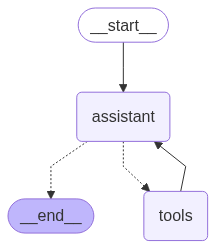

In [35]:
# build graph

graph_builder = StateGraph(MessagesState)

graph_builder.add_node('assistant', assistant)
graph_builder.add_node('tools', ToolNode(arithmetic_tools))

graph_builder.add_edge(START, 'assistant')
graph_builder.add_conditional_edges(
    'assistant',
    tools_condition
)

graph_builder.add_edge('tools', 'assistant')
react_graph = graph_builder.compile()

# show graph
# notice there is not explicit connection from 'assistant' to end
# remember from documentation of 'add_conditional_edges':
# Use in the conditional_edge to route to the ToolNode if the last message has tool calls. Otherwise, route to the end.

drawGraph(react_graph)

In [36]:
test_msg = [HumanMessage(content='Add 3 and 4. Multiply the output by 2. Divide the output by 5')]
test_msg = react_graph.invoke({'messages' : test_msg})

for m in test_msg['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================
Tool Calls:
  add (call_ebINoVrc0dJk52Lw0y74mgf9)
 Call ID: call_ebINoVrc0dJk52Lw0y74mgf9
  Args:
    a: 3
    b: 4
  multiply (call_yXdvhqSQMSEWIbhTh2FMXAm5)
 Call ID: call_yXdvhqSQMSEWIbhTh2FMXAm5
  Args:
    a: 2
    b: 0
  divide (call_aJa49SxH196QhbpgEjAWMavA)
 Call ID: call_aJa49SxH196QhbpgEjAWMavA
  Args:
    a: 0
    b: 5
================================= Tool Message =================================
Name: add

7
================================= Tool Message =================================
Name: multiply

0
================================= Tool Message =================================
Name: divide

0.0
================================== Ai Message ==================================
Tool Calls:
  add (call_xmCU9hQy55NGDpBx9RcfSS8d)
 Call ID: call_xmCU9

---

## Breakpoint And Human-In-Loop (HIL)
Breakpoints provide a simple way to stop the graph at a specific step to seek human approval before proceeding. Breakpoints are a common pattern in Human-In-Loop interaction.

In [37]:
from langgraph.graph import MessagesState

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

from IPython.display import Image, display

import random

In [38]:
# define the nodes function

def multiply(a : int, b: int) -> int:
    """
    Multiply a and b
    Args:
       a: first int
       b: second int
    """
    return a * b

def add (a: int, b: int) -> int:
    """
    Add a and b
    Args:
       a: first int
       b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """
    Divide a and b
    Args:
       a: first int
       b: second int
    """
    return a / b

In [39]:
model = ChatOpenAI(
    model = 'gpt-4o-mini'
)

arithmetic_tools = [add, multiply, divide]
model_with_tools = model.bind_tools(arithmetic_tools)

# system message
sys_msg = SystemMessage(
    content="You are a helful assistant tasked with performing arithmetic operations."
)

# helpful assistant node
def assistant(state: MessagesState):
    return {"messages" : [model_with_tools.invoke([sys_msg] + state['messages'])]}

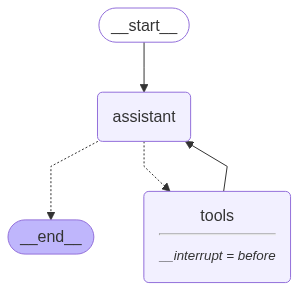

In [40]:
# build graph

graph_builder = StateGraph(MessagesState)

graph_builder.add_node('assistant', assistant)
graph_builder.add_node('tools', ToolNode(arithmetic_tools))

graph_builder.add_edge(START, 'assistant')
graph_builder.add_conditional_edges(
    'assistant',
    tools_condition
)

graph_builder.add_edge('tools', 'assistant')

# set up memory
memory = MemorySaver()

# execution will be interrupted befoe the 'tools' node
breakpoint_graph = graph_builder.compile(interrupt_before=['tools'], checkpointer=memory)

# show graph
# notice there is not explicit connection from 'assistant' to end
# remember from documentation of 'add_conditional_edges':
# Use in the conditional_edge to route to the ToolNode if the last message has tool calls. Otherwise, route to the end.

drawGraph(breakpoint_graph)

In [41]:
thread = {"configurable": {"thread_id" : str(random.randint(1, 100))}}

# Input
initial_input = {"messages": "Add 3 and 4. Multiply the output by 2. Divide the output by 5."}

# Run the graph until the first interruption
for event in breakpoint_graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

user_approval = input("Do you want to continue (yes/no):")

while (user_approval.lower() == 'yes'):
    for event in breakpoint_graph.stream(None, thread, stream_mode="values"):
        event['messages'][-1].pretty_print()

    # if there is no more node to run, stop the execution
    # you can comment out thee code to observe the execution flow
    # it will keep running the last operation
    if len(breakpoint_graph.get_state(thread).next) == 0:
        break

    user_approval = input("Do you want to continue (yes/no):")
    if user_approval.lower() != 'yes':
        print("Operation cancelled by user.")
        break

# Inputs:
# Do you want to continue (yes/no):yes
# Do you want to continue (yes/no):yes

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2. Divide the output by 5.
================================== Ai Message ==================================
Tool Calls:
  add (call_yodQ8gZzD9KX8dZDWrOnMhzW)
 Call ID: call_yodQ8gZzD9KX8dZDWrOnMhzW
  Args:
    a: 3
    b: 4
Do you want to continue (yes/no):yes
================================== Ai Message ==================================
Tool Calls:
  add (call_yodQ8gZzD9KX8dZDWrOnMhzW)
 Call ID: call_yodQ8gZzD9KX8dZDWrOnMhzW
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  multiply (call_RnCSqlnWeRY6mQX7bOe7hJBe)
 Call ID: call_RnCSqlnWeRY6mQX7bOe7hJBe
  Args:
    a: 7
    b: 2
  divide (call_h6lBjteQpYqe5WBazxRX6P1L)
 Call ID: call_h6lBjteQpYqe5WBazxRX6P1L
  Args:
    a: 7
    b: 5
Do you want to contin

## Editing Graph State
Earlier, we interrupt the graph and allow user to accept an action or not. Now we are going to modify the state. Breakpoints are also opportunities to modify the graph state.

In [42]:
from langgraph.graph import MessagesState

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

from IPython.display import Image, display

import random

In [43]:
# define the nodes function

def multiply(a : int, b: int) -> int:
    """
    Multiply a and b
    Args:
       a: first int
       b: second int
    """
    return a * b

def add (a: int, b: int) -> int:
    """
    Add a and b
    Args:
       a: first int
       b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """
    Divide a and b
    Args:
       a: first int
       b: second int
    """
    return a / b

In [44]:
model = ChatOpenAI(
    model = 'gpt-4o-mini'
)

arithmetic_tools = [add, multiply, divide]
model_with_tools = model.bind_tools(arithmetic_tools)

# system message
sys_msg = SystemMessage(
    content="You are a helful assistant tasked with performing arithmetic operations."
)

# helpful assistant node
def assistant(state: MessagesState):
    return {"messages" : [model_with_tools.invoke([sys_msg] + state['messages'])]}

# added this for human_feedback creation
def human_feedback(stateLMessageState):
    pass

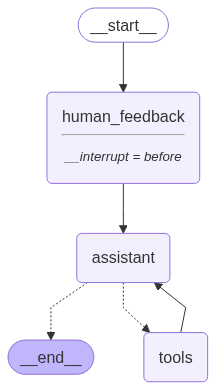

In [45]:
# build graph

graph_builder = StateGraph(MessagesState)

graph_builder.add_node('assistant', assistant)
graph_builder.add_node('tools', ToolNode(arithmetic_tools))

# added this node "human_feedback"
graph_builder.add_node("human_feedback", human_feedback)

graph_builder.add_edge(START, 'human_feedback')
graph_builder.add_edge("human_feedback", "assistant")
graph_builder.add_conditional_edges(
    'assistant',
    tools_condition
)

graph_builder.add_edge('tools', 'assistant')

# set up memory
memory = MemorySaver()

# execution will be interrupted befoe the 'human_feedback' node
breakpoint_graph = graph_builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# show graph
# notice there is not explicit connection from 'assistant' to end
# remember from documentation of 'add_conditional_edges':
# Use in the conditional_edge to route to the ToolNode if the last message has tool calls. Otherwise, route to the end.

drawGraph(breakpoint_graph)

In [46]:
thread = {"configurable": {"thread_id" : str(random.randint(1, 100))}}

# Input
# deliberately put in a divide by 0
initial_input = {"messages": "Add 3 and 4. Multiply the output by 2. Divide the output by 0."}

# Run the graph until the first interruption
for event in breakpoint_graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

user_want_to_edit = input("Do you want to edit the prompt (yes/no):")
if user_want_to_edit.lower() == 'yes':
    new_prompt = input('Tell me the new prompt:')
    breakpoint_graph.update_state(thread, {"messages" : new_prompt}, as_node="human_feedback")

    for event in breakpoint_graph.stream(None, thread, stream_mode="values"):
        event['messages'][-1].pretty_print()
else:
    print("Operation cancelled by user.")

# Note:
# When ask to edit the prompt, you need to reply as it is not a replacement operation. Enter yes to edit the prompt.

# Possibilities:
# 1. Enter (copy text within quotes) → "Ignore the last instruction. Do this: Add 3 and 4. Multiply the output by 2. Divide the output by 10."
# 2. Enter (copy text within quotes) → "There is a typo error. Instead of divide by 0, change it to divide by 10."

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2. Divide the output by 0.
Do you want to edit the prompt (yes/no):yes
Tell me the new prompt:There is a typo error. Instead of divide by 0, change it to divide by 10.
================================ Human Message =================================

There is a typo error. Instead of divide by 0, change it to divide by 10.
================================== Ai Message ==================================
Tool Calls:
  add (call_bkkceZt7xaxFVO9VVDwfE4Js)
 Call ID: call_bkkceZt7xaxFVO9VVDwfE4Js
  Args:
    a: 3
    b: 4
  multiply (call_ieESy2swPwM3mKeAKXU4UR9y)
 Call ID: call_ieESy2swPwM3mKeAKXU4UR9y
  Args:
    a: 7
    b: 2
  divide (call_egmyWCbTEzIETglKVCi2xYuO)
 Call ID: call_egmyWCbTEzIETglKVCi2xYuO
  Args:
    a: 14
    b: 10
================================= Tool Message =================================
Name: divide

1.4
================================== Ai Messag

## Alternative Method:
Alternative method to draw a graph is to print it using ascii characters.

Note: grandalf library needs to be installed.

In [47]:
breakpoint_graph.get_graph().print_ascii()

        +-----------+         
        | __start__ |         
        +-----------+         
               *              
               *              
               *              
      +----------------+      
      | human_feedback |      
      +----------------+      
               *              
               *              
               *              
        +-----------+         
        | assistant |         
        +-----------+         
          .         *         
        ..           **       
       .               *      
+---------+         +-------+ 
| __end__ |         | tools | 
+---------+         +-------+ 
